In [1]:
import re,os,glob,json,math
import numpy as np
from numpy import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 

In [2]:
import dataUtils

dataUtils.preProcessData('/home/chris/anaconda3/aclImdb')
dictionary = dataUtils.createWordDictionary('/home/chris/anaconda3/aclImdb')

sorted_dict = {}
sorted_keys = sorted(dictionary, key=dictionary.get,reverse=True) 

for w in sorted_keys:
    sorted_dict[w] = dictionary[w]
    
with open('/home/chris/anaconda3/dict.json', 'w') as f :
    json.dump(sorted_dict, f)        

/home/chris/anaconda3/aclImdb/train/pos
/home/chris/anaconda3/aclImdb/train/neg
/home/chris/anaconda3/aclImdb/test/pos
/home/chris/anaconda3/aclImdb/test/neg
/home/chris/anaconda3/aclImdb/train/pos
/home/chris/anaconda3/aclImdb/train/neg


In [2]:
with open('/home/chris/anaconda3/dict.json', 'r') as f :
    dictionary = json.load(f)

In [2]:
import dataUtils
from datetime import datetime     

for i in [0,100,1000,10000,20000,40000,60000]:
    for j in [100,500,1000,2000,4000,5000]:
        print(datetime.now())    
        array = dataUtils.textToArray('/home/chris/anaconda3/aclImdb',dictionary,i,j)
        np.save(str(i)+"_"+str(j), array )  
        print(datetime.now())

2021-01-06 21:11:35.992364


NameError: name 'dictionary' is not defined

In [2]:
import logReg 
for i in [0,100,1000,10000,20000,40000,60000]:
    for j in [100,500,1000,2000,4000]:
        array = np.load(str(i)+"_"+str(j)+".npy")
        np.random.shuffle(array)
        X = array[:,:array.shape[1]-1]
        y = array[:,array.shape[1]-1:]

        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6,test_size=0.4, random_state=101)
        X_test, X_cv, y_test, y_cv= train_test_split(X_valid, y_valid, train_size=0.5,test_size=0.5, random_state=101)
        
        w = logReg.gradientAscent(X_train,y_train,0.0001,1,0.3,0)
        p1 = logReg.predictP(w,X_test)

        print(str(i)+" "+str(j)+" Accuracy:",metrics.accuracy_score(y_test, p1))
        array = None
        

/home/chris/Documents/CS/5/ai/Untitled Folder/logReg.py:43: RuntimeWarning: divide by zero encountered in log
  return y.dot( np.log(p) ) + (1-y).dot(np.log(1-p))


0 100 Accuracy: 0.6466
0 500 Accuracy: 0.7611
0 1000 Accuracy: 0.8387
0 2000 Accuracy: 0.8374
0 4000 Accuracy: 0.8472
100 100 Accuracy: 0.6228
100 500 Accuracy: 0.7439
100 1000 Accuracy: 0.8096
100 2000 Accuracy: 0.846
100 4000 Accuracy: 0.8365
1000 100 Accuracy: 0.5675
1000 500 Accuracy: 0.6603
1000 1000 Accuracy: 0.7114
1000 2000 Accuracy: 0.7627
1000 4000 Accuracy: 0.7711
10000 100 Accuracy: 0.509
10000 500 Accuracy: 0.514
10000 1000 Accuracy: 0.5456
10000 2000 Accuracy: 0.5561
10000 4000 Accuracy: 0.5638
20000 100 Accuracy: 0.5012
20000 500 Accuracy: 0.499
20000 1000 Accuracy: 0.5104
20000 2000 Accuracy: 0.5054
20000 4000 Accuracy: 0.5066
40000 100 Accuracy: 0.5022
40000 500 Accuracy: 0.5057
40000 1000 Accuracy: 0.5131
40000 2000 Accuracy: 0.5168
40000 4000 Accuracy: 0.5057
60000 100 Accuracy: 0.4966
60000 500 Accuracy: 0.5043
60000 1000 Accuracy: 0.5038
60000 2000 Accuracy: 0.506
60000 4000 Accuracy: 0.5192


In [21]:
array = np.load("100_2000.npy")
np.random.shuffle(array)

X = array[:,:array.shape[1]-1]
y = array[:,array.shape[1]-1:]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.6,test_size=0.4, random_state=101)
X_test, X_cv, y_test, y_cv= train_test_split(X_valid, y_valid, train_size=0.5,test_size=0.5, random_state=101)

In [22]:
import logReg       #takes a minute
pr1=[]
pr2=[]
for i in range(1,X_train.shape[0],2000):
    w = logReg.gradientAscent(X_train[:i],y_train[:i],0.0001,1,0.3,0)
    p1 = logReg.predictP(w,X_test)
    pr1.append(logReg.accuracy(w,X_cv,y_cv) )
    pr2.append(logReg.accuracy(w,X_train[:i],y_train[:i]) )

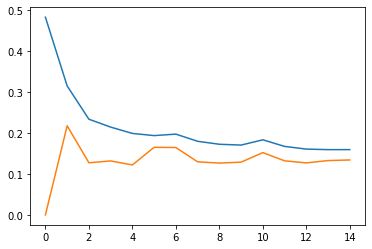

In [24]:
pr1 = [1-p for p in pr1]     # loss% = 1-accuracy%
pr2 = [1-p for p in pr2]

plt.plot(range(len(pr1)),pr1 )
plt.plot(range(len(pr2)),pr2 )

In [27]:
import logReg 
w = logReg.gradientAscent(X_train,y_train,0.0001,1,0.3,0)
p1 = logReg.predictP(w,X_test)

print("Accuracy:",metrics.accuracy_score(y_test, p1))
print(classification_report(y_test,p1))


Accuracy: 0.8382
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84      4985
         1.0       0.84      0.84      0.84      5015

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [19]:
from datetime import datetime              #takes ~30 secs
import naiveBayes

print(datetime.now())    
rlts = naiveBayes.bayesArr(X_train,y_train,X_test)
print(datetime.now())

print("Accuracy:",metrics.accuracy_score(y_test, rlts))
print(classification_report(y_test,rlts))

2021-01-06 17:34:03.936778
2021-01-06 17:39:54.670584


In [21]:
import naiveBayes
pr1=[]
pr2=[]
for i in range(1,X_train.shape[0],10000):
    pr1.append(metrics.accuracy_score(naiveBayes.bayesArr(X_train[:i],y_train[:i],X_cv),y_cv) )
    pr2.append(metrics.accuracy_score(naiveBayes.bayesArr(X_train[:i],y_train[:i],X_train[:i]),y_train[:i]) )
    
    
    

/home/chris/Documents/CS/5/ai/Untitled Folder/naiveBayes.py:23: RuntimeWarning: divide by zero encountered in log
  prob[c]= np.log( ycounts[c] / ysize)+1


KeyboardInterrupt: 

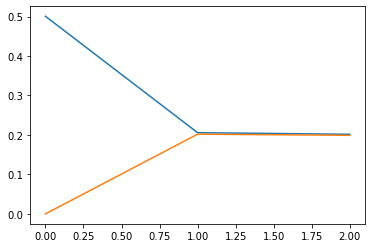

In [16]:
pr1 = [1-p for p in pr1]
pr2 = [1-p for p in pr2]


plt.plot(range(len(pr1)),pr1 )
plt.plot(range(len(pr2)),pr2 )